# Analyze the Times Higher Education World University Rankings for 2016


![THE logo](http://trinitynews.ie/wp/wp-content/uploads/2014/10/Times-Higher-Education-Ranking-Pic1.jpg)

This notebook uses Times Higher Education (THE) World University rankings for 2016 data to analyze the following: 
- How the performance of the universities across different indicators is evaluated
- Which and where are the best universities
- What makes these universities stand out from the rest

This notebook runs on Python 2 with Spark 2.0.

## Table of contents
1. [Import the libraries](#libraries)
2. [Import the dataset](#dataset)
3. [Tidy up the data](#tidy)
4. [Analyze the ranking data](#rank)
5. [Analyze the performance indicators](#performance)
6. [Remove outliers](#outliers)
7. [Correlation between the different indicators](#correlation)
8. [Next steps](#nextsteps)

## 1. Import the libraries<a id="libraries"></a>

In [18]:
# Import libraries and suppress warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

## 2. Import the dataset<a id="dataset"></a>

Download the THE World University Ranking 2016 dataset as follows:
1. Go <a href="https://www.kaggle.com/mylesoneill/world-university-rankings/data" target="_blank" rel="noopener no referrer">Kaggle: World University Rankings</a>, log in, and then download `timesData.csv` to your computer.
3. Load the `timesData.csv` file into your notebook. Click the **Data** icon on the notebook action bar. Drop each file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project. For more information, see <a href="https://datascience.ibm.com/docs/content/analyze-data/load-and-access-data.html" target="_blank" rel="noopener noreferrer">Load and access data</a>.
4. To load the data from the `timesData.csv` file into a R DataFrame, click in the next code cell and select **Insert to code > Insert Pandas DataFrame** under the file name.
6. Run the cell.

In [19]:
# Removed code for importing the csv file

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011


We will consider the year 2016 for our analysis because according to the detailed methodology <a href="https://www.timeshighereducation.com/news/ranking-methodology-2016" target="_blank" rel="noopener no referrer">here</a>, the underlying data for calculating rankings changed in 2016.

In [20]:
df1 = df_data_1[df_data_1['year'] == 2016]

In [21]:
# Lets get a brief overview of the data
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1803 to 2602
Data columns (total 14 columns):
world_rank                800 non-null object
university_name           800 non-null object
country                   800 non-null object
teaching                  800 non-null float64
international             800 non-null object
research                  800 non-null float64
citations                 800 non-null float64
income                    800 non-null object
total_score               800 non-null object
num_students              793 non-null object
student_staff_ratio       793 non-null float64
international_students    790 non-null object
female_male_ratio         739 non-null object
year                      800 non-null int64
dtypes: float64(4), int64(1), object(9)
memory usage: 93.8+ KB


As we can see, the THE dataset captures a lot of information about each university, but note these two observations:
- Many columns which should be of type `int`,`float` are instead of type `object`, which means we need to examine them more closely before doing any analysis
- Data is missing from some columns

Let's have a look at the data:

In [22]:
df1.describe()

,teaching,research,citations,student_staff_ratio,year
count,800.0000,800.000000,800.00000,793.000000,800
mean,31.5840,28.128625,51.30975,19.116393,2016
std,14.9854,19.532270,27.04544,12.522003,0
min,9.9000,2.900000,1.20000,0.600000,2016
25%,21.0000,14.350000,27.52500,12.300000,2016
50%,27.0000,22.100000,50.30000,16.600000,2016
75%,37.5000,35.525000,74.90000,22.400000,2016
max,95.6000,99.000000,100.00000,162.600000,2016


## 3. Tidy up the data<a id="tidy"></a>

If a value for the indicator **income** is not provided, we assign it a value of  <i>20</i>. This is in line with THE methodology explained <a href="https://www.timeshighereducation.com/news/ranking-methodology-2016#survey-answer" target="_blank" rel="noopener no referrer">here</a>: 

<i>On the rare occasions when a particular data point is not provided – which affects only low-weighted indicators such as industrial income – we enter a low estimate between the average value of the indicators and the lowest value reported: the 25th percentile of the other indicators. By doing this, we avoid penalising an institution too harshly with a “zero” value for data that it overlooks or does not provide, but we do not reward it for withholding them.</i>

In [23]:
for x in range(len(df1)):
    idx = df1.iloc[x].name
    inc = df1['income'].iloc[x]
    students = df1['num_students'].iloc[x]
    int_students = df1['international_students'].iloc[x]
    fmr = df1['female_male_ratio'].iloc[x]
    
    # Convert '-' to NaN in income
    if "-" in inc:
        df1.set_value(idx, 'income', 20) # Arbitrary low value
    
    # Format the numbers properly
    if type(students) != float:
        students1 = students.replace(",", "")
        df1.set_value(idx, 'num_students', students1)
        
    # Remove the '%' sign 
    if int_students and type(int_students) != float:
        int_students1 = int_students.replace("%", "")
        df1.set_value(idx, 'international_students', int_students1)
        
    # Convert ratios of the form '43:57' to decimal ratios and convert '-' to NaN
    if type(fmr) != float:
        if ":" in fmr:
            arr2 = [float(x) for x in fmr.split() if x.isdigit()]
            if arr2[0] != 0 and arr2[1] != 0:
                ratio1 = arr2[0]/arr2[1]
                df1.set_value(idx, 'female_male_ratio', ratio1)
            else:
                df1.set_value(idx, 'female_male_ratio', 100.0) # One university has all female students         
        else:
            df1.set_value(idx, 'female_male_ratio', np.NaN)
            


In [24]:
# Lets change the type of each of the columns to float, for easier analysis.
df1['international'] = df1['international'].astype(float)
df1['income'] = df1['income'].astype(float)
df1['num_students'] = df1['num_students'].astype(float)
df1['international_students'] = df1['international_students'].astype(float)
df1['female_male_ratio'] = df1['female_male_ratio'].astype(float)

## 4. Analyze the ranking data<a id="rank"></a>

To calculate the final score for a university, different performance indicators have been given different weighting by THE. Let's analyze the data and do the following:
- Calculate how many types of ranks we have currently
- Calculate the total score for each entry based on the formula provided by THE
- Sort the universities by the new score
- Calculate how many universities have an equal score
- Find out which are the best universities in the world according to THE
- Visualize which countries have the best universities

<b>Calculate how many types of ranks we have currently:</b>

In [25]:
rank_int = [x for x in df1["world_rank"] if x.isdigit()]
rank_eq = [x for x in df1["world_rank"] if "=" in x]
rank_hyph = [x for x in df1["world_rank"] if "-" in x]
print "Simple numeric ranks ", len(rank_int)
print "Ranks with = sign ", len(rank_eq)
print "Ranks with - sign ", len(rank_hyph)

print sorted(set(rank_hyph))

Simple numeric ranks  111
Ranks with = sign  89
Ranks with - sign  600
['201-250', '251-300', '301-350', '351-400', '401-500', '501-600', '601-800']


Only the top 200 universities are actually given ranks. The rest are grouped into classes.
Some universities are ranked equally.

<b>Calculate the total score for each entry based on the formula provided by THE:</b>

In [26]:
for x in range(len(df1)):
    idx = df1.iloc[x].name  
    new_score = df1.loc[idx,"teaching"]*0.3 + df1.loc[idx,"research"]*0.3 + df1.loc[idx,"citations"]*0.3 + df1.loc[idx,"international"]*0.075 + df1.loc[idx,"income"]*0.025
    df1.set_value(idx, 'total_score', new_score)
    

<b>Sort the universities by the new score:</b>

In [27]:
df1.sort_values('total_score', ascending=False, inplace=True)

<b>Calculate how many universities have an equal score:</b>

In [28]:
dups = df1["total_score"].value_counts()
dups[dups > 1]

17.8725    2
27.0150    2
17.1500    2
14.2075    2
33.4925    2
50.0725    2
20.6725    2
Name: total_score, dtype: int64

In [32]:
df1.iloc[:, 0] = np.arange(1, 801)

Increase the rank of one of the universities having equal score by 0.1. This is to enable further analysis, and also to ensure that equally scored universities are not ranked differently (for example, 39 and 40).

In [33]:
arr1 = []

for x in range(len(df1)):
    rank = x + 1
    score = df1['total_score'].iloc[x]
    idx = df1.iloc[x].name    
    if score not in arr1:
        arr1.append(score)
    else:
        rank1 = rank + 0.1
        df1.set_value(idx, 'world_rank', rank1)


<b>Now let's see which are the best universities in the world according to THE:</b>

In [34]:
df1[df1["world_rank"] <= 10].sort_values(["world_rank"])

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
1803,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.145,2243,6.9,27,0.492537,2016
1804,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.1675,19919,11.6,34,0.851852,2016
1805,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.885,15596,7.8,22,0.724138,2016
1806,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8075,18812,11.8,34,0.851852,2016
1807,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,91.995,11074,9.0,33,0.587302,2016
1808,6,Harvard University,United States of America,83.6,77.2,99.0,99.8,45.2,91.64,20152,8.9,25,NaN,2016
1809,7,Princeton University,United States of America,85.1,78.5,91.9,99.3,52.1,90.08,7929,8.4,27,0.818182,2016
1810,8,Imperial College London,United Kingdom,83.3,96.0,88.5,96.7,53.7,89.0925,15060,11.7,51,0.587302,2016
1811,9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,77.0,97.9,95.0,91.1,80.0,88.2725,18178,14.7,37,0.449275,2016
1812,10,University of Chicago,United States of America,85.7,65.0,88.9,99.2,36.6,87.93,14221,6.9,21,0.724138,2016


All of them have a very high score in <b>research</b>, <b>teaching</b> and <b>citations</b>.

<b>Visualize which countries have the best universities:</b>

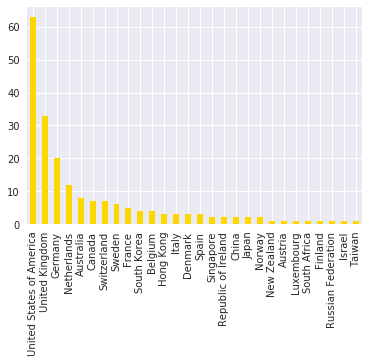

In [35]:
df1["country"][df1["world_rank"] < 200].value_counts().plot(kind='bar',color='gold')

The US and UK lead the list by far, followed by Germany.

Take a new look at the data we now have:

In [36]:
df1.describe()

,world_rank,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,female_male_ratio,year
count,800.0000,800.0000,800.000000,800.000000,800.00000,800.000000,793.000000,793.000000,790.000000,736.000000,800
mean,400.5000,31.5840,48.500375,28.128625,51.30975,45.626875,24161.264817,19.116393,12.702532,1.216970,2016
std,231.0844,14.9854,23.690816,19.532270,27.04544,20.872462,22569.224842,12.522003,10.676075,3.676528,0
min,1.0000,9.9000,7.100000,2.900000,1.20000,20.000000,462.000000,0.600000,0.000000,0.010101,2016
25%,200.7500,21.0000,29.450000,14.350000,27.52500,30.900000,12331.000000,12.300000,5.000000,0.818182,2016
50%,400.5000,27.0000,45.700000,22.100000,50.30000,37.700000,20174.000000,16.600000,10.000000,1.083333,2016
75%,600.2500,37.5000,65.450000,35.525000,74.90000,53.700000,29700.000000,22.400000,18.000000,1.325581,2016
max,800.0000,95.6000,99.900000,99.000000,100.00000,100.000000,379231.000000,162.600000,82.000000,100.000000,2016


## 5. Analyze the performance indicators<a id="performance"></a>

Analyze the relationship between ranking and these performance indicators:
- Citations
- Research
- Teaching
- Income
- International
- Number of students
- Student to staff ratio
- International students
- Female to male student ration

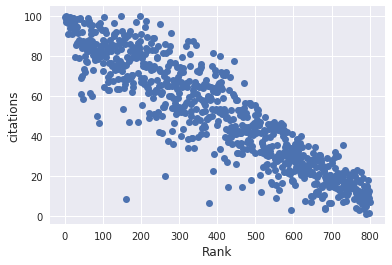

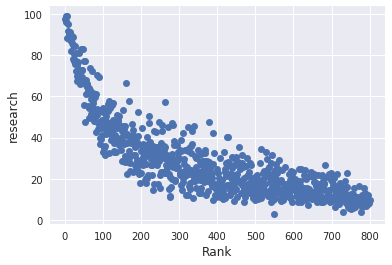

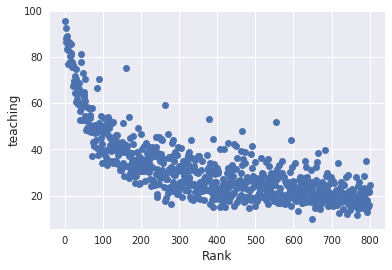

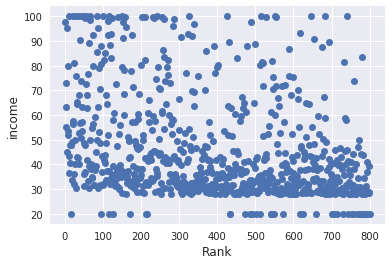

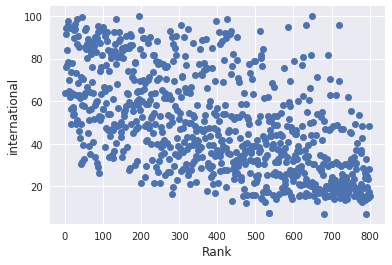

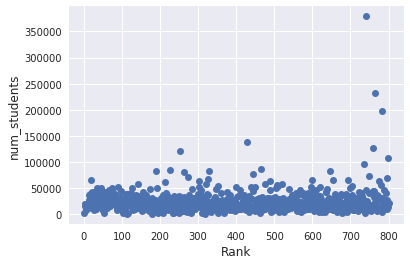

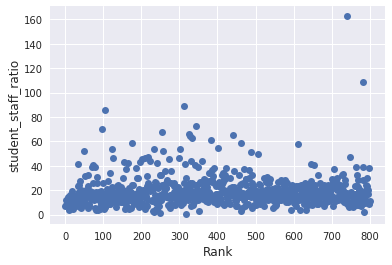

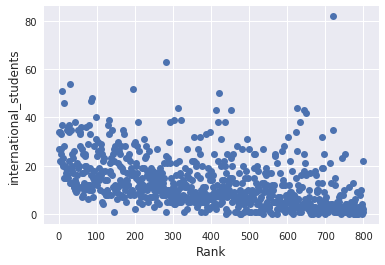

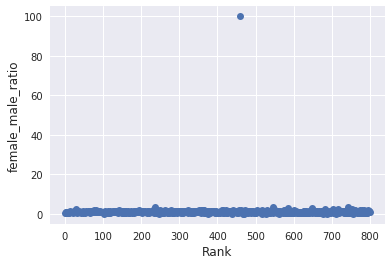

In [37]:
cols = ["citations", "research", "teaching", "income", "international", "num_students", "student_staff_ratio", "international_students", "female_male_ratio"]
for col in cols:
    df2 = df1[pd.notnull(df1[col])]
    plt.figure()
    plt.plot(df2["world_rank"], df2[col], "o")
    plt.xlabel("Rank", fontsize=12)
    plt.ylabel(col, fontsize=12)

## 6. Remove outliers<a id="outlier"></a>

Based on the graphs above, we can clearly see some outliers in the data. These are:
- Universities with huge number of students
- A female-only university

Remove the outliers before proceeding:

In [38]:
df1[df1["num_students"] > 200000].sort_values(["num_students"], ascending=[False])

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
2413,741,Anadolu University,Turkey,12.2,14.3,22.6,10.9,100.0,17.2825,379231,162.6,1,3.545455,2016
2430,765,Cairo University,Egypt,18.9,31.0,11.1,11.9,30.3,15.6525,231941,39.1,3,0.886792,2016


In [39]:
df1[df1["student_staff_ratio"] > 100].sort_values(["student_staff_ratio"], ascending=[False])

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
2413,741,Anadolu University,Turkey,12.2,14.3,22.6,10.9,100.0,17.2825,379231,162.6,1,3.545455,2016
2562,783,University of South Africa,South Africa,18.4,28.7,11.3,9.4,28.8,14.6025,197102,108.5,9,1.857143,2016


In [40]:
df1[df1["international_students"] > 80].sort_values(["international_students"], ascending=[False])

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
2411,720,American University of Sharjah,United Arab Emirates,12.4,95.6,10.6,13.3,33.3,18.8925,5226,14.1,82,0.923077,2016


In [41]:
df1[df1["female_male_ratio"] > 90].sort_values(["female_male_ratio"], ascending=[False])

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
2227,460,Ewha Womans University,South Korea,23.9,34.3,18.3,50.4,57.6,31.7925,17625,14.4,6,100,2016


In [42]:
drop_idx = [2413, 2430, 2562, 2411, 2227]
df1 = df1.drop(drop_idx, axis=0)

## 7. Correlation between the different indicators<a id="correlation"></a>
Now we can look at the correlation between ranking score and performance indicators.

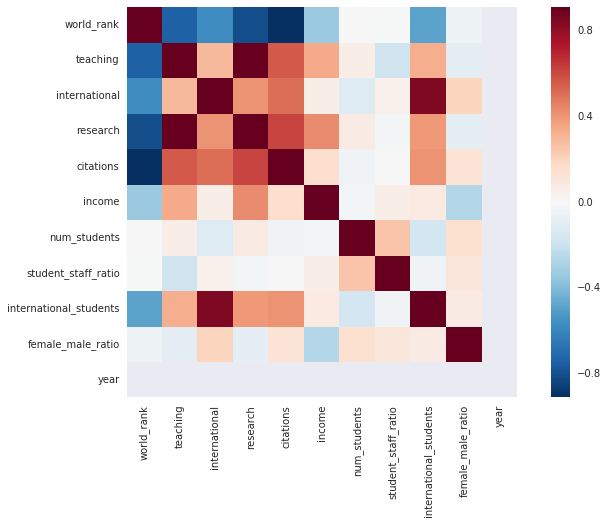

In [24]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

This is a helpful graph! A number of observations here:
-  The rank of a university is most negatively correlated to the <b>citation</b> score, that is, the higher the citation score, the better the rank.
-  The citation score is highly correlated with <b>teaching</b>/<b>research</b>, which is expected.
-  <b>international_students</b> is highly correlated to <b>teaching</b>/<b>research</b>. Again, this is expected, because international students are attracted by a university's research and faculty reputation.
-  <b>international_students</b> is highly correlated to <b>international</b>, which represents the international outlook of the university (including staff and international research collaborations).
-  <b>num_students</b> is highly correlated to <b>student_staff_ratio</b>. Of course, the greater the number of students, the greater the student_staff_ratio.
-  <b>student_staff_ratio</b> is slightly negatively correlated to <b>teaching</b>. Teaching quality suffers if there is a higher number of students per teacher.
-  <b>research</b> is correlated to <b>income</b>. Because <b>income</b> is a measure of how much <i>"research income an institution earns from industry"</i>, hence better the research, more the income
-  An interesting slight negative correlation between <b>female_male_ratio</b> and <b>income</b>, which means more males study in higher income universities. As income is directly correlated to the quality of research, this seems to suggest that more males are into research (across disciplines) than females.

However, the highest correlation is between <b>teaching</b> and <b>research</b>. This is an expected correlation, but THE considers teaching and research to be different indicators when calculating the final score and gives them equal weighting. 
What if we simply omit the research score and double the weighting for teaching? Do the scores change by much?

In [25]:
mod_score = []

for x in range(len(df1)):
    idx = df1.iloc[x].name  
    new_score = df1.loc[idx,"teaching"]*0.6 + df1.loc[idx,"citations"]*0.3 + df1.loc[idx,"international"]*0.075 + df1.loc[idx,"income"]*0.025
    mod_score.append(new_score)

In [26]:
df1['total_score'] = df1['total_score'].astype(float)
np.corrcoef(mod_score, df1["total_score"])[0,1]

0.99109033999375939

There is still a 99% correlation! It seems THE can save itself some work and make its surveys simpler by removing the research parameter because this parameter does not significantly alter the score/rankings.

## 8. Next steps <a id="nextsteps"></a>

Here are some suggestions about how we could further analyze the ranking data:
- Explore the relationship between research and citation; does a high research score always mean a high citation score?
- Explore the gender ratio and research score; are there actually less females in research fields? Filter out science universities from the list and check the gender ratio.
- Compare the rankings to the 2017 rankings.
- Correlate the rankings to the countries' education budget. This requires you to get the country expenditure details.

### Citations
- <a href="https://www.timeshighereducation.com/world-university-rankings" target="_blank" rel="noopener no referrer">THE world university rankings</a>
- <a href="https://www.timeshighereducation.com/news/ranking-methodology-2016" target="_blank" rel="noopener no referrer">THE world university ranking methodology 2016</a>
- <a href="https://www.kaggle.com/mylesoneill/world-university-rankings/data" target="_blank" rel="noopener no referrer">World University Rankings:
Investigate the best universities in the world</a>

### Author
**Vaibhav Mathur** is an QA Specialist at IBM, India.

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.